In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai as meta_fai
import fastai.basics as fai
import fastai.vision as fv
import torch
import pandas as pd
import gc

In [3]:
planet = fv.untar_data(fai.URLs.PLANET_SAMPLE)

In [4]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360, max_lighting=0.1, max_zoom=1.05,max_warp=0.05)

In [5]:
def load_planet_data(img_size, batch_size):
    return (fv.ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
              .random_split_by_pct(0.2, seed=666) #pct = percentage
              .label_from_df(label_delim = ' ') #dataframe
              .transform(tfms, size=img_size)
              .databunch(bs=batch_size)
              .normalize(fv.imagenet_stats))


In [6]:
data = load_planet_data(128, 64)

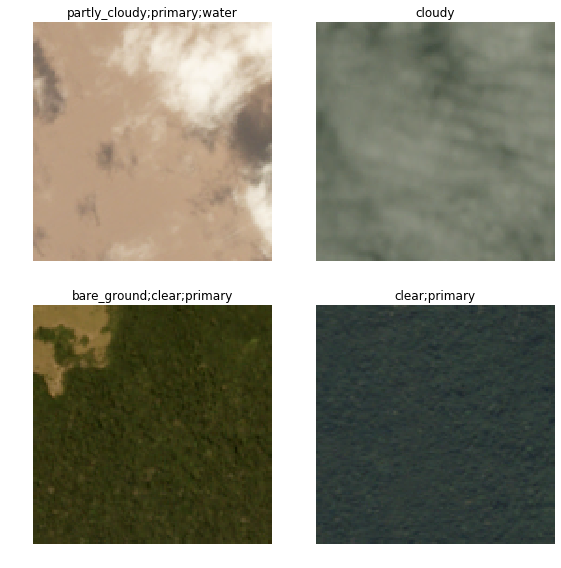

In [7]:
data.show_batch(rows=2)

In [8]:
def f2_score_01(input, target):
    return fai.fbeta(input, target, thresh=0.1, beta=2)
def f2_score_02(input, target):
    return fai.fbeta(input, target, thresh=0.2, beta=2)
def f2_score_025(input, target):
    return fai.fbeta(input, target, thresh=0.25, beta=2)
def f2_score_03(input, target):
    return fai.fbeta(input, target, thresh=0.3, beta=2)
def f2_score_04(input, target):
    return fai.fbeta(input, target, thresh=0.4, beta=2)

In [9]:
metrics = [f2_score_01, f2_score_02, f2_score_025, f2_score_03, f2_score_04]
learn = fv.create_cnn(data, fv.models.resnet101, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/jupyter/.torch/models/resnet101-5d3b4d8f.pth
100%|██████████| 178728960/178728960 [00:36<00:00, 4845017.24it/s]


In [10]:
learn.fit_one_cycle(5,3e-2)

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.653010,0.716156,0.472132,0.491951,0.503187,0.508029,0.516281
2,0.399830,0.587416,0.660811,0.634151,0.627400,0.617260,0.578274
3,0.308821,0.339232,0.744095,0.753740,0.745426,0.746217,0.735174
4,0.255123,0.165693,0.847381,0.863048,0.863569,0.863724,0.861649
5,0.218146,0.124625,0.889345,0.895994,0.887397,0.882208,0.865909


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


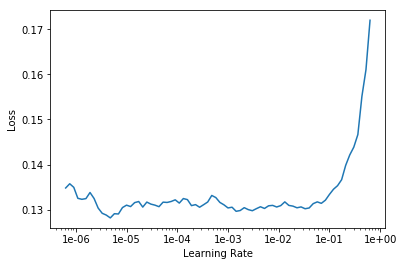

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5,max_lr=4e-3)

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.136187,0.119158,0.900211,0.904747,0.896012,0.887107,0.867908
2,0.129966,0.119552,0.903093,0.887856,0.890339,0.885655,0.868243
3,0.126386,0.113639,0.905564,0.908637,0.897156,0.887581,0.865106
4,0.122519,0.114345,0.903464,0.904701,0.901700,0.896476,0.884290
5,0.120148,0.112445,0.901495,0.908095,0.904703,0.899126,0.889803


In [13]:
torch.save(learn.model.state_dict(), "models/stage-1-r101.pth")

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.111069,0.115871,0.892516,0.902624,0.902583,0.899621,0.883360
2,0.116807,0.130371,0.893893,0.889127,0.882200,0.883062,0.858465
3,0.122014,0.173385,0.872062,0.864173,0.859249,0.848967,0.831711
4,0.124691,0.152456,0.863831,0.870343,0.869296,0.863905,0.850748
5,0.122338,0.127426,0.889166,0.887271,0.884020,0.877456,0.856547
6,0.117434,0.109777,0.902961,0.906840,0.909770,0.911929,0.886336
7,0.112595,0.108580,0.909800,0.915797,0.914613,0.907783,0.893585
8,0.109810,0.109026,0.909350,0.913866,0.912392,0.907218,0.895002


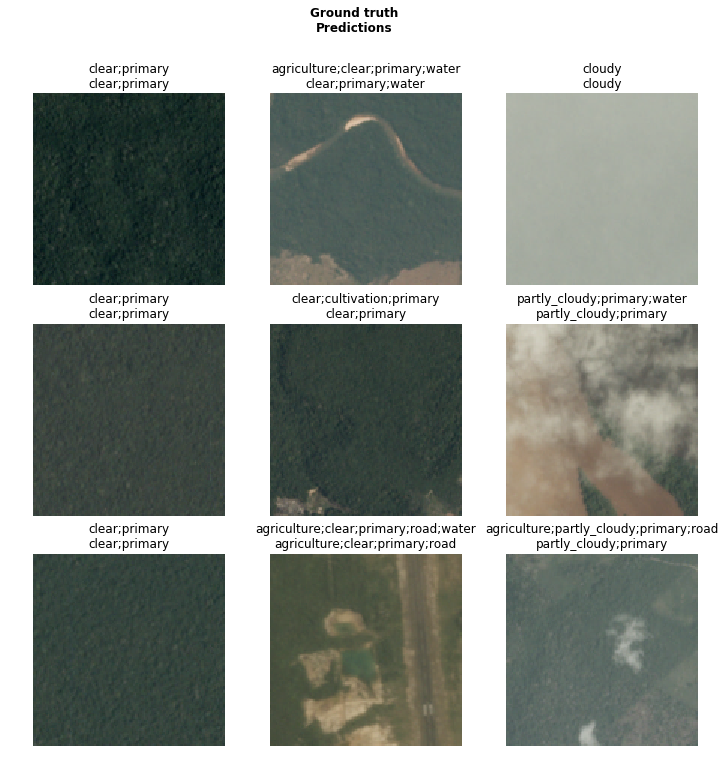

In [16]:
learn.show_results(rows=3)

In [17]:
learn.save("stage-2-r101")

In [20]:
img_sizes = [160, 192, 224, 256]
batch_sizes = [64, 64, 64, 48]

In [21]:
lr = 1e-3
for sz, bs in zip(img_sizes, batch_sizes):
    learn.data = load_planet_data(sz,bs)
    gc.collect()
    learn.fit_one_cycle(8, slice(lr/10, lr))
    learn.save(f"stage3-r101-{sz}")

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.110517,0.121828,0.893434,0.906460,0.897035,0.896590,0.888432
2,0.104682,0.138318,0.897520,0.881877,0.879846,0.871840,0.861505
3,0.102483,0.123747,0.912797,0.907940,0.905102,0.900809,0.873780
4,0.101048,0.134185,0.887357,0.880723,0.874389,0.867589,0.857271
5,0.099852,0.117091,0.903088,0.903579,0.892014,0.889521,0.879016
6,0.096271,0.107610,0.915539,0.913024,0.912305,0.901931,0.888149
7,0.091332,0.105970,0.916792,0.912503,0.906603,0.901234,0.893134
8,0.088207,0.104596,0.921450,0.910470,0.907014,0.902290,0.891325


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.078580,0.108135,0.915478,0.911582,0.903335,0.894992,0.880452
2,0.078820,0.104724,0.911854,0.916616,0.909744,0.901429,0.887085
3,0.083303,0.141572,0.886839,0.889427,0.885370,0.878735,0.868370
4,0.087127,0.121104,0.904312,0.906865,0.907873,0.902566,0.891538
5,0.088530,0.127975,0.896837,0.896515,0.884414,0.879415,0.874398
6,0.087625,0.115043,0.909222,0.900142,0.893792,0.886235,0.873081
7,0.082382,0.105880,0.908517,0.905027,0.904427,0.902014,0.893426
8,0.079628,0.106290,0.909317,0.906476,0.904255,0.898835,0.888874


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.071373,0.107238,0.912508,0.903584,0.906072,0.896372,0.888686
2,0.068793,0.119143,0.903906,0.903364,0.892977,0.887438,0.878363
3,0.075655,0.130041,0.900708,0.893247,0.888174,0.883560,0.880702
4,0.081062,0.122767,0.899589,0.900421,0.895636,0.888538,0.881453
5,0.079302,0.118833,0.915902,0.898583,0.893480,0.883027,0.874630
6,0.077823,0.110779,0.914946,0.908603,0.901103,0.895169,0.873923
7,0.074685,0.101550,0.918985,0.914984,0.907881,0.896487,0.886735
8,0.071809,0.102241,0.917027,0.912464,0.910397,0.898550,0.882168


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.068695,0.110750,0.913559,0.903779,0.902312,0.899579,0.876910
2,0.068847,0.126257,0.898790,0.894907,0.885745,0.881445,0.873705
3,0.082010,0.153715,0.877133,0.864145,0.853891,0.848419,0.832987
4,0.088813,0.135518,0.899790,0.886844,0.890359,0.888299,0.881839
5,0.089086,0.110867,0.907556,0.908852,0.898132,0.894225,0.881700
6,0.085013,0.111436,0.908907,0.902758,0.896408,0.894004,0.883005
7,0.079725,0.105112,0.914840,0.910182,0.908340,0.901473,0.895669
8,0.074784,0.104394,0.913890,0.915438,0.904480,0.901673,0.890273


In [ ]:
learner = 
learner.load(f"stage3-r101-160")

In [ ]:
learn.show_results(rows=3)